# Elastic wave equation implementation on a staggered grid + Free surface B.C + explosive source

This is a first attempt at implemenenting the elastic wave equation as described in:

[1] Jean Virieux (1986). ”P-SV wave propagation in heterogeneous media: Velocity‐stress finite‐difference method.” GEOPHYSICS, 51(4), 889-901. https://doi.org/10.1190/1.1442147

The current version actually attempts to mirror the FDELMODC implementation by Jan Thorbecke:

[2] https://janth.home.xs4all.nl/Software/fdelmodcManual.pdf

## Explosive source

We will first attempt to replicate the explosive source test case described in [1], Figure 4. We start by defining the source signature $g(t)$, the derivative of a Gaussian pulse, given by Eq 4:

$$g(t) = -2 \alpha(t - t_0)e^{-\alpha(t-t_0)^2}$$

Explosive source is simulated by setting the off-diagonal elements of stress tensor to zero $$\tau_{xy}(x=x_{0},z=z_{0}, t) =\tau_{yx}(x=x_{0},z=z_{0}, t)=0$$ and diagnonal elements to the source signature, defined above $$\tau_{xx}(x=x_{0},z=z_{0}, t) =\tau_{yy}(x=x_{0},z=z_{0}, t)=g(t)$$ 
where $x_{0}, z_{0}$ are the coordinates of the source

**N.B. The explosive source cannot be placed on the surface, since stresses are defined to be zero on the free surface. This notebook hence serves to illustrate wave propagation in an elastic medium**

In [1]:
from devito import *
from examples.seismic.source import WaveletSource, RickerSource, GaborSource, TimeAxis, Receiver
from examples.seismic import plot_image, Model
import numpy as np
import matplotlib.pyplot as plt
import math

from sympy import init_printing, latex
init_printing(use_latex='mathjax')

In [2]:
sh=100
sp=10.0
origin=(0., 0., 0.)
shape=(sh, sh, sh)
spacing=(sp, sp, sp)
vp = 2.0*np.ones(shape)
vs = 1.0*np.ones(shape)
b = np.ones(shape)   ### CAUTION: 1/density

so=4 ### Space order of discretization

model = Model(origin=origin, shape=shape, spacing=spacing, 
              space_order=so, bcs='mask', fs=True, vp=vp, vs=vs, b=b, nbl=25)
grid = model.grid

Operator `initdamp` run in 0.01 s
Operator `padfunc` run in 0.01 s
Operator `padfunc` run in 0.01 s
Operator `padfunc` run in 0.01 s


In [3]:
model.grid.subdomains
print("Shape of entire domain:",model.grid.subdomains['domain'].shape)
print("Shape of free-surface domain:",model.grid.subdomains['fsdomain'].shape)
print("Shape of interior:",model.grid.subdomains['interior'].shape)
print("Shape of physical domain:",model.grid.subdomains['physdomain'].shape)

Shape of entire domain: (150, 150, 125)
Shape of free-surface domain: (150, 150, 4)
Shape of interior: (148, 148, 123)
Shape of physical domain: (150, 150, 121)


# CFL condition (stability) and numerical dispersion condition 

In [4]:
### CFL condition: Devito automatically calculates the time-stepping required to ensure stability 
### Refer to eqn 10 of FDELMODC manual for example
h = np.max(spacing)
dt_eq10 = (h*0.606) / 2.  ###For fourth order scheme, Courant number is 0.606, dx=3.75 and vmax=2.0
dt_devito = model.critical_dt
print("Time stepping that satisfies CFL is", dt_eq10, "ms")
print(dt_devito)

Time stepping that satisfies CFL is 3.03 ms
2.474


In [5]:
np.isclose(dt_eq10, dt_devito, rtol=1e-02, atol=1e-02)

False

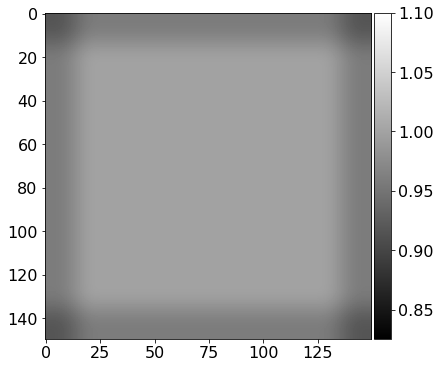

Maximum frequency that can be propagated without numerical dispesion is 0.02 kHz


In [6]:
### We need a minimum of 5 points per wavelength for dispersion free propagation
### Refer to equation 11 of the FDELMODC manual
plot_image(model.damp.data[:,:,25])
fmax = 1.0/(5*h)
print("Maximum frequency that can be propagated without numerical dispesion is", fmax, "kHz")

In [7]:
class DGaussSource(WaveletSource):
    
    def wavelet(self, f0, t):
        a = 0.004
        return -2.*a*(t - 1/f0) * np.exp(-a * (t - 1/f0)**2)

# Timestep size from Eq. 7 with V_p=2000. and dx=7.5
t0, tn = 0., 1000.
dt = 0.5*model.critical_dt   
time_range = TimeAxis(start=t0, stop=tn, step=dt)
src = RickerSource(name='src', grid=grid, f0=0.01, time_range=time_range)
print(src.coordinates.data[:])
src.coordinates.data[:] = [sh*sp/2, sh*sp/2, sh*sp/2] # Source is injected at the center
print(dt)

[[0. 0. 0.]]
1.2369999885559082


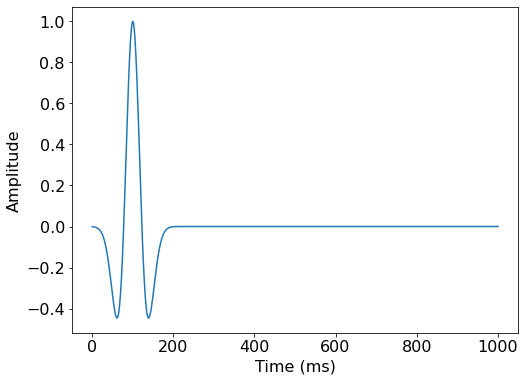

In [8]:
#NBVAL_SKIP

src.show()

Text(0, 0.5, 'Amplitude')

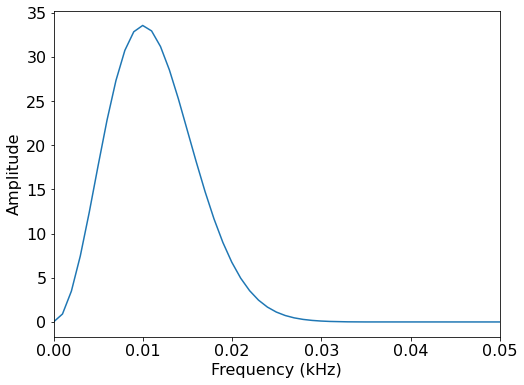

In [9]:
freqs = np.fft.rfftfreq(src.data.shape[0], d=dt)
spec = np.fft.rfft(src.data.flatten())
plt.plot(freqs,np.abs(spec))
plt.xlim([0, 0.05])
plt.xlabel("Frequency (kHz)")
plt.ylabel("Amplitude")

In [10]:
# Now we create the velocity and pressure fields
v = VectorTimeFunction(name='v', grid=grid, space_order=so, time_order=1)
tau = TensorTimeFunction(name='t', grid=grid, space_order=so, time_order=1)

In [11]:
# Now let's try and create the staggered updates
t = grid.stepping_dim
time = grid.time_dim

# The source injection term
src_xx = src.inject(field=tau.forward[0,0], expr=src)
src_zz = src.inject(field=tau.forward[2,2], expr=src)
src_yy = src.inject(field=tau.forward[1,1], expr=src)

# Define receivers to record horizontal and vertical components of particle velocity
#Note: the moon data may be accelerations, but one integrates recorded data in time to obtain velocities


nrec = 10000
recx = Receiver(name="rech", grid=model.grid, npoint=nrec, time_range=time_range)
recy = Receiver(name="recv", grid=model.grid, npoint=nrec, time_range=time_range)
recz = Receiver(name="recv", grid=model.grid, npoint=nrec, time_range=time_range)
recx.coordinates.data[:, -1] = 0.
recy.coordinates.data[:, -1] = 0.
recz.coordinates.data[:, -1] = 0.
c=int(math.sqrt(nrec))
#10000 receivers on the surface in a 100*100 sqaure
for i in range(c):
    recx.coordinates.data[(i)*c:(i+1)*c,0]=i*model.domain_size[0]/(c-1)
    recy.coordinates.data[(i)*c:(i+1)*c,0]=i*model.domain_size[0]/(c-1)
    recz.coordinates.data[(i)*c:(i+1)*c,0]=i*model.domain_size[0]/(c-1)
    for j in range(10):
        recx.coordinates.data[i*c+j,1]=j*model.domain_size[0]/(c-1)
        recy.coordinates.data[i*c+j,1]=j*model.domain_size[0]/(c-1)
        recz.coordinates.data[i*c+j,1]=j*model.domain_size[0]/(c-1)
        
        
rec_horiz = recx.interpolate(expr=v[0])
rec_vert = recy.interpolate(expr=v[1])
rec_depth=recz.interpolate(expr=v[2])
# Thorbecke's parameter notation

mu = model.mu
l = model.lam
ro = model.b

# fdelmodc reference implementation
u_v = Eq(v.forward, (model.damp) *(v + dt*ro*div(tau)), subdomain=model.grid.subdomains['domain'])
u_t = Eq(tau.forward, tau + (model.damp) *(dt * l * diag(div(v.forward)) 
        + dt * mu * (grad(v.forward) + grad(v.forward).T)), 
         subdomain=model.grid.subdomains['physdomain'])

print(src.coordinates.data)
print(recx.coordinates.data.shape)
print(model.domain_size)

[[500. 500. 500.]]
(10000, 3)
(990.0, 990.0, 990.0)


In [12]:
u_v

Eq(Vector(v_x(t + dt, x + h_x/2, y, z), v_y(t + dt, x, y + h_y/2, z), v_z(t + dt, x, y, z + h_z/2)), Vector((1.23699998855591*(Derivative(t_xx(t, x, y, z), x) + Derivative(t_xy(t, x + h_x/2, y + h_y/2, z), y) + Derivative(t_xz(t, x + h_x/2, y, z + h_z/2), z))*b(x, y, z) + v_x(t, x + h_x/2, y, z))*damp(x, y, z), (1.23699998855591*(Derivative(t_xy(t, x + h_x/2, y + h_y/2, z), x) + Derivative(t_yy(t, x, y, z), y) + Derivative(t_yz(t, x, y + h_y/2, z + h_z/2), z))*b(x, y, z) + v_y(t, x, y + h_y/2, z))*damp(x, y, z), (1.23699998855591*(Derivative(t_xz(t, x + h_x/2, y, z + h_z/2), x) + Derivative(t_yz(t, x, y + h_y/2, z + h_z/2), y) + Derivative(t_zz(t, x, y, z), z))*b(x, y, z) + v_z(t, x, y, z + h_z/2))*damp(x, y, z)))

In [13]:
u_t

Eq(SymmetricTensor( t_xx(t + dt, x, y, z), t_xy(t + dt, x + h_x/2, y + h_y/2, z), t_xz(t + dt, x + h_x/2, y, z + h_z/2), t_yy(t + dt, x, y, z), t_yz(t + dt, x, y + h_y/2, z + h_z/2), t_zz(t + dt, x, y, z),), Tensor( (1.23699998855591*(Derivative(v_x(t + dt, x + h_x/2, y, z), x) + Derivative(v_y(t + dt, x, y + h_y/2, z), y) + Derivative(v_z(t + dt, x, y, z + h_z/2), z))*lam(x, y, z) + 2.47399997711182*mu(x, y, z)*Derivative(v_x(t + dt, x + h_x/2, y, z), x))*damp(x, y, z) + t_xx(t, x, y, z), 1.23699998855591*(Derivative(v_x(t + dt, x + h_x/2, y, z), y) + Derivative(v_y(t + dt, x, y + h_y/2, z), x))*damp(x, y, z)*mu(x, y, z) + t_xy(t, x + h_x/2, y + h_y/2, z), 1.23699998855591*(Derivative(v_x(t + dt, x + h_x/2, y, z), z) + Derivative(v_z(t + dt, x, y, z + h_z/2), x))*damp(x, y, z)*mu(x, y, z) + t_xz(t, x + h_x/2, y, z + h_z/2), 1.23699998855591*(Derivative(v_x(t + dt, x + h_x/2, y, z), y) + Derivative(v_y(t + dt, x, y + h_y/2, z), x))*damp(x, y, z)*mu(x, y, z) + t_xy(t, x + h_x/2, y + h_y

In [14]:
model.grid.subdomains['fsdomain'].shape

(150, 150, 4)

## Free surface boundary condition
## Refer to pages 21-22 of FDELMODC or eqns 3.80a--d of Fichtner

In [15]:
def freesurface_top(model, tau_func, v_func):
    time = tau_func.grid.stepping_dim
    pos = int(max(tau_func.space_order, v_func.space_order)/2)
    x = tau_func.grid.dimensions[0]
    y = tau_func.grid.dimensions[1]
    print(tau[2,1])
    print(pos)
    tau_zz_0 = [Eq(tau[2,2][time+1, x,y, pos], 0., subdomain=model.grid.subdomains['fsdomain'])] 
    tau_zz_mirror = [Eq(tau[2,2][time+1, x, y, i], -tau[2,2][time+1, x, y, 2*pos-i],subdomain=model.grid.subdomains['fsdomain']) for i in range(pos)]
    
    tau_xy_mirror = [Eq(tau[0,1][time+1, x, y, i], -tau[0,1][time+1, x, y, 2*pos-i],subdomain=model.grid.subdomains['fsdomain']) for i in range(pos)]
    
    tau_yx_mirror = [Eq(tau[1,0][time+1, x, y, i], -tau[1,0][time+1, x, y, 2*pos-i],subdomain=model.grid.subdomains['fsdomain']) for i in range(pos)]
    
    tau_xz_mirror = [Eq(tau[2,0][time+1, x, y, i], -tau[2,0][time+1, x, y, 2*pos-i],subdomain=model.grid.subdomains['fsdomain']) for i in range(pos)]
    
    tau_zx_mirror = [Eq(tau[0,2][time+1, x, y, i], -tau[0,2][time+1, x, y, 2*pos-i],subdomain=model.grid.subdomains['fsdomain']) for i in range(pos)]
    
    tau_yz_mirror = [Eq(tau[2,1][time+1, x, y, i], -tau[2,1][time+1, x, y, 2*pos-i],subdomain=model.grid.subdomains['fsdomain']) for i in range(pos)]
    
    tau_zy_mirror = [Eq(tau[1,2][time+1, x, y, i], -tau[1,2][time+1, x, y, 2*pos-i],subdomain=model.grid.subdomains['fsdomain']) for i in range(pos)]
    
    tau_xx = [Eq(tau[0,0].forward, l*grad(v.forward)[0,0]+ 2.0*mu * (grad(v.forward)[0,0]),subdomain=model.grid.subdomains['fsdomain'])]
    
    tau_yy = [Eq(tau[1,1].forward, l*grad(v.forward)[1,1]+ 2.0*mu * (grad(v.forward)[1,1]), subdomain=model.grid.subdomains['fsdomain'])]
    
    return (tau_zz_0 + tau_zz_mirror + tau_xy_mirror + tau_yx_mirror +tau_xz_mirror+tau_zx_mirror +tau_yz_mirror
          +tau_zy_mirror+ tau_xx + tau_yy)

bc = freesurface_top(model, tau, v)

t_yz(t, x, y + h_y/2, z + h_z/2)
2


In [16]:
bc ##Not sure why these equations get printed differently, but this will do for now! 

⎡                                                                             
⎢t_zz[t + 1, x, y, 2] = 0.0, t_zz[t + 1, x, y, 0] = -t_zz[t + 1, x, y, 4], t_z
⎣                                                                             

                                                                              
z[t + 1, x, y, 1] = -t_zz[t + 1, x, y, 3], t_xy[t + 1, x, y, 0] = -t_xy[t + 1,
                                                                              

                                                                              
 x, y, 4], t_xy[t + 1, x, y, 1] = -t_xy[t + 1, x, y, 3], t_xy[t + 1, x, y, 0] 
                                                                              

                                                                              
= -t_xy[t + 1, x, y, 4], t_xy[t + 1, x, y, 1] = -t_xy[t + 1, x, y, 3], t_xz[t 
                                                                              

                                                

In [17]:
u_v

Eq(Vector(v_x(t + dt, x + h_x/2, y, z), v_y(t + dt, x, y + h_y/2, z), v_z(t + dt, x, y, z + h_z/2)), Vector((1.23699998855591*(Derivative(t_xx(t, x, y, z), x) + Derivative(t_xy(t, x + h_x/2, y + h_y/2, z), y) + Derivative(t_xz(t, x + h_x/2, y, z + h_z/2), z))*b(x, y, z) + v_x(t, x + h_x/2, y, z))*damp(x, y, z), (1.23699998855591*(Derivative(t_xy(t, x + h_x/2, y + h_y/2, z), x) + Derivative(t_yy(t, x, y, z), y) + Derivative(t_yz(t, x, y + h_y/2, z + h_z/2), z))*b(x, y, z) + v_y(t, x, y + h_y/2, z))*damp(x, y, z), (1.23699998855591*(Derivative(t_xz(t, x + h_x/2, y, z + h_z/2), x) + Derivative(t_yz(t, x, y + h_y/2, z + h_z/2), y) + Derivative(t_zz(t, x, y, z), z))*b(x, y, z) + v_z(t, x, y, z + h_z/2))*damp(x, y, z)))

In [18]:
op = Operator([u_v] + [u_t] + bc + src_xx + src_yy+ src_zz + rec_horiz + rec_vert + rec_depth)

In [19]:
#NBVAL_IGNORE_OUTPUT

op()

Operator `Kernel` run in 31.52 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
  PerfEntry(time=30.798193000000005, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
 (PerfKey(name='section1', rank=None),
  PerfEntry(time=0.001745000000000004, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
 (PerfKey(name='section2', rank=None),
  PerfEntry(time=0.26936399999999977, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
 (PerfKey(name='section3', rank=None),
  PerfEntry(time=0.44736900000000135, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

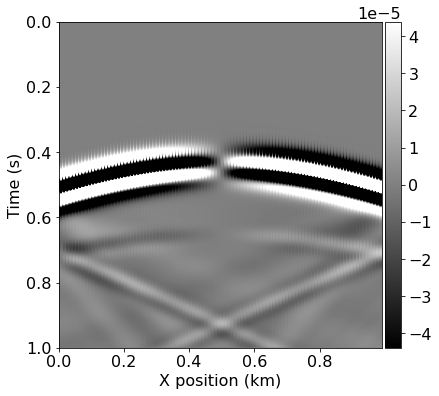

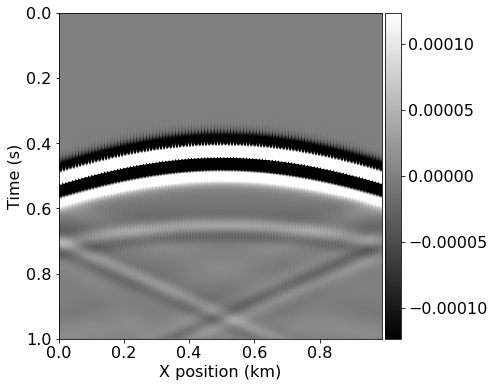

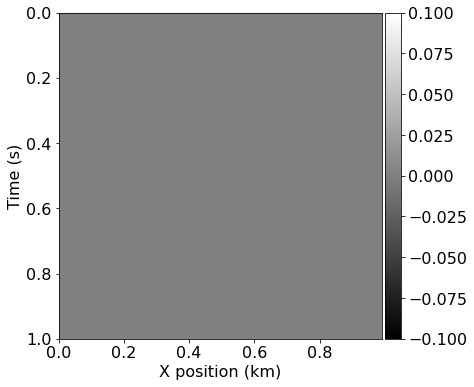

In [20]:
from examples.seismic import plot_shotrecord
plot_shotrecord(recx.data, model, t0, tn, colorbar=True)
plot_shotrecord(recy.data, model, t0, tn, colorbar=True)
plot_shotrecord(recz.data, model, t0, tn, colorbar=True)

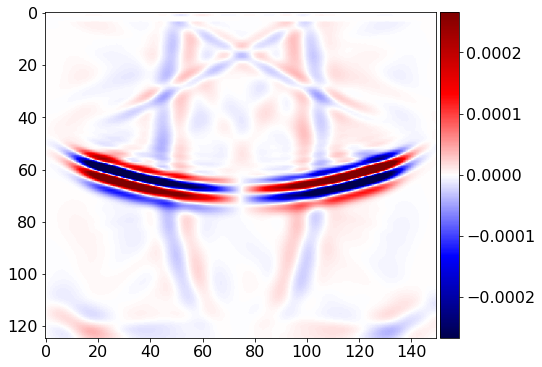

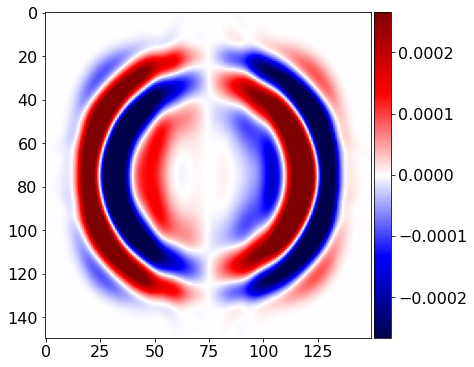

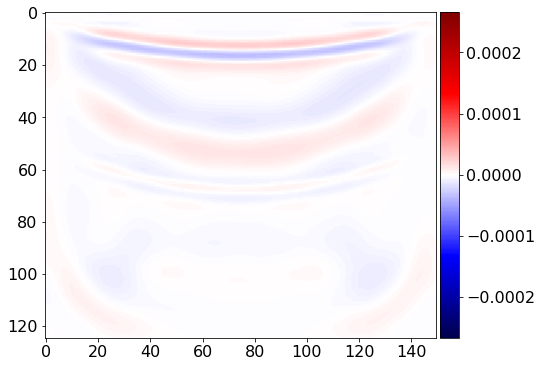

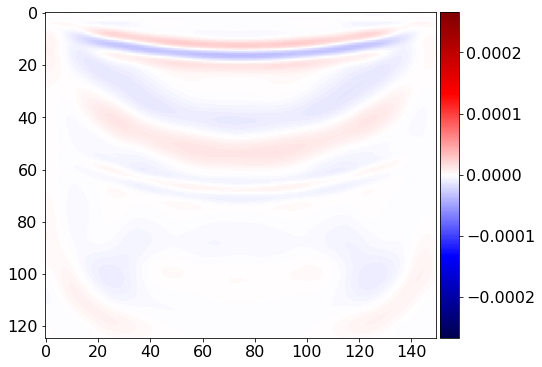

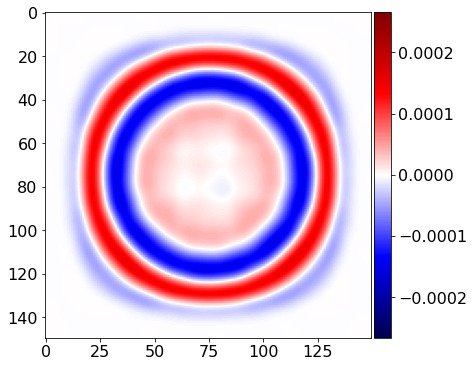

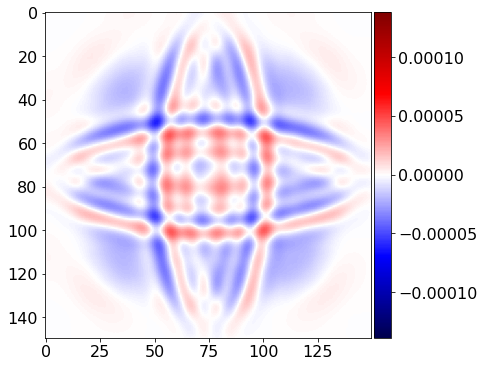

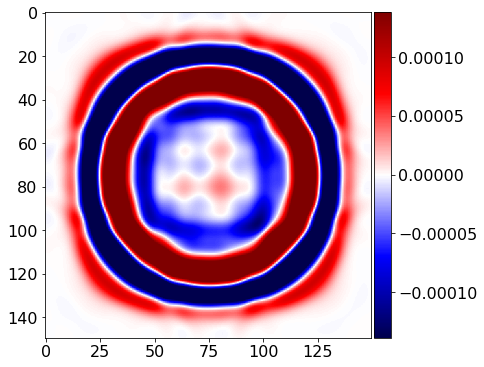

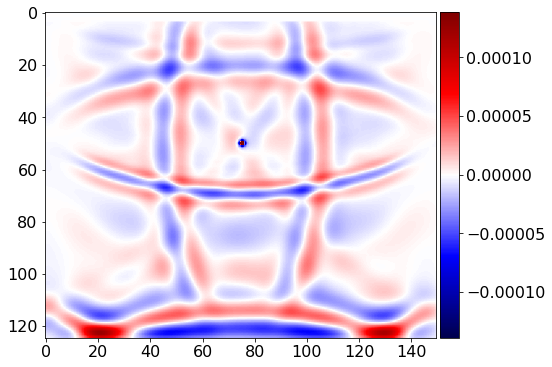

In [21]:

scale_v = max(np.percentile(np.abs(v[0].data), 99), np.percentile(np.abs(v[1].data),99),np.percentile(np.abs(v[2].data), 99))
scale_tau = max(np.percentile(np.abs(tau[0,0].data),99), np.percentile(np.abs(tau[0,1].data),99), 
                   np.percentile(np.abs(tau[1,0].data),99), np.percentile(np.abs(tau[1,1].data),99))
# Let's see what we got....
plot_image(v[0].data[0,:,75,:], vmin=-scale_v, vmax=scale_v, cmap="seismic")
plot_image(v[0].data[0,:,:,62], vmin=-scale_v, vmax=scale_v, cmap="seismic")
plot_image(v[0].data[0,75,:,:], vmin=-scale_v, vmax=scale_v, cmap="seismic")
plot_image(v[1].data[0,:,75,:], vmin=-scale_v, vmax=scale_v, cmap="seismic")
plot_image(v[2].data[0,:,:,62], vmin=-scale_v, vmax=scale_v, cmap="seismic")
plot_image(tau[2,2].data[0,:,:,10], vmin=-scale_tau, vmax=scale_tau, cmap="seismic")
plot_image(tau[2,2].data[0,:,:,62], vmin=-scale_tau, vmax=scale_tau, cmap="seismic")
plot_image(tau[1,1].data[0,:,75,:], vmin=-scale_tau, vmax=scale_tau, cmap="seismic")

# **TODO: compare with fdelmod for accuracy!**

2.474
(810, 10000)


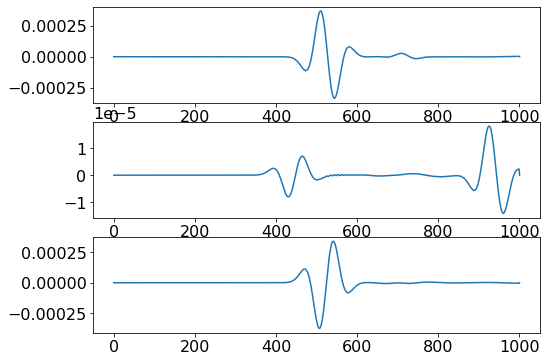

In [22]:
print(model.critical_dt)
t=np.arange(start=t0,stop=tn+dt,step=dt)
print(recx.data.shape)
plt.subplot(3,1,1)
plt.plot(t,recx.data[:,9999])# avoiding boundaries, just left

plt.subplot(3,1,2)
plt.plot(t,recx.data[:,4950])

plt.subplot(3,1,3)
plt.plot(t,recx.data[:,1])

2.474


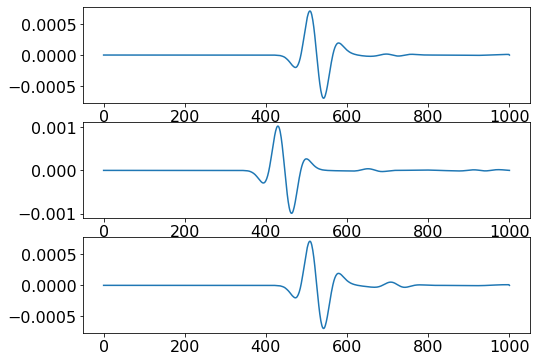

In [23]:
print(model.critical_dt)
t=np.arange(start=t0,stop=tn+dt,step=dt)

plt.subplot(3,1,1)
plt.plot(t,recy.data[:,9999])# avoiding boundaries, just left

plt.subplot(3,1,2)
plt.plot(t,recy.data[:,4950])

plt.subplot(3,1,3)
plt.plot(t,recy.data[:,1])

2.474


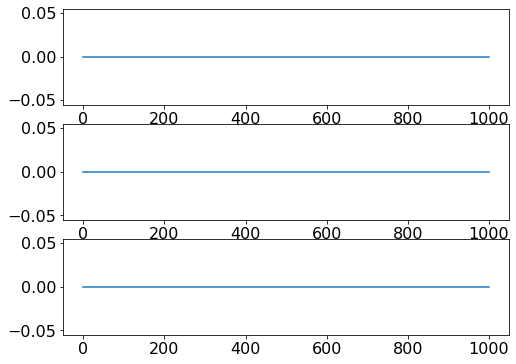

In [24]:
print(model.critical_dt)
t=np.arange(start=t0,stop=tn+dt,step=dt)

plt.subplot(3,1,1)
plt.plot(t,recz.data[:,49])# avoiding boundaries, just left

plt.subplot(3,1,2)
plt.plot(t,recz.data[:,25])

plt.subplot(3,1,3)
plt.plot(t,recz.data[:,1])